# Import appropriate modules

In [2]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm import tqdm, trange
import math
import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Helper Functions

In [3]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def simple_fidelity(k,g):
    g2 = g**2
    k2 = k**2
    return  1 - (4*g2+g2**2)/(16*k2)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

# Simulator

In [65]:
# Driven couplings between states
chosen_states_coupling_labels = np.array([(0,8,1),(1,10,2),(2,10,3),(1,8,3)])
# chosen_states_coupling_labels = np.array([(0,-6,0),(1,-6,0),(0,-8,0),(1,-8,0)])
# chosen_states_coupling_labels = np.array([(0,-6,0),(1,-6,0),(0,-8,0),(1,-4,5)])
chosen_coupling_labels = [
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 979.891 * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*2

# At what magnetic field
# chosen_bi = field_to_bi(890)

# Only simulate other states that have strong off resonant coupling
# cutoff = 0.9999999 # =0 for only these =1 for all states
        
# Simulation resolution
T_STEPS =  [803989,314927,195931,65519,41443,21319,9391,50][1]

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*2

H_BAR = scipy.constants.hbar
D_0 = 4.0861590000000005e-30

In [66]:
# Get Angular Frequency Matrix Diagonal for each B
angular = np.array([0,980e6,981e6])
chosen_number_of_states = len(angular)

couplings = np.array([[0, 1, 0.2],
                      [1, 0, 0],
                      [0.2, 0, 0]])

chosen_coupling_indices = [(0,1),(0,2)]
coupling_detunings = [0,2e4]

chosen_coupling_indices = [(0,2)]
coupling_detunings = [2e4]

# Get driving frequencies & polarisations
driving = []
E_i = []
for (i1,i2), pulse_time,detuning in zip(chosen_coupling_indices, chosen_pulse_time,coupling_detunings):
    driving.append(np.abs(angular[i1]-angular[i2])+detuning)
    E_i.append((2*np.pi*H_BAR) / (D_0 * couplings[i1,i2] * pulse_time))
driving = np.array(driving)
print("Driving (rad/s):", driving)
E_i = np.array(E_i,dtype=np.double)
print("E (V/m):", E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 10
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,0] = np.sqrt(1)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]

resolution=20
probabilities = np.abs(state_vector[::resolution,:])**2

Driving (rad/s): [9.810e+08]
E (V/m): [8.274e-01]


100%|████████████████████████████████| 314926/314926 [00:03<00:00, 98720.44it/s]


0.0910940379


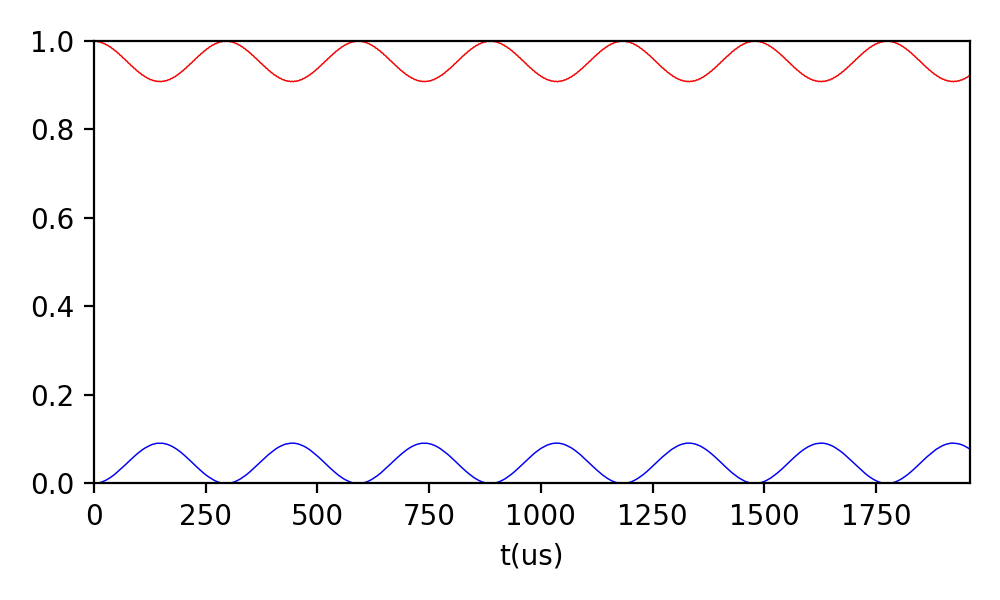

In [67]:
# Plot results
fig,ax = plt.subplots(figsize=(5,3))
ax.set_xlabel('t(us)')
ax.set_ylim(0,1)
ax.set_xlim(0,TIME*1e6)
# states_string = ','#.join([f'${label_d_to_latex_string(label)}$' for label in chosen_states_coupling_labels])
# ax.set_title('{},\n {} @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {} states simulated'
#              .format("",
#                      "",
#                      "",
#                      round(global_pulse_time*1e6),
#                      T_STEPS,
#                      chosen_number_of_states))

c = ['red','green','blue','purple','grey','grey']
ax.plot(times[::resolution]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.5);
for i in range(chosen_number_of_states):
    ax.plot(times[::resolution]*1e6,probabilities[:,i],c=c[i],linewidth=0.5);
    
print(f"{np.max(probabilities[:,2]):.10f}")
# fig.savefig(f'../images/{MOLECULE_STRING}-2-state-qubit-sim-a.pdf')

# 0.9956479464
# 0.9954616013
# Hyp: 0.9909437997